## Modeling Rush Yards Per Game 

https://www.statsmodels.org/devel/mixed_linear.html

https://www.statsmodels.org/devel/gam.html

https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html

#### Modeling Framework 
    1. Fit 3 models for each type of data 
        * GAM and / or spline model - because we have panel data 
    2. Tune spline parameters 
    3. Train / test split - not cross validate 
        * work on back testing modeling framework 
    4. Output: 
        1. Prediction
        2. A notion of variance or uncertainty for optimization 
    5. Pipeline to injest new data 

In [1]:
# %load ../api_access_snippet.py
#import library
import gspread 
#Service client credential from oauth2client
from oauth2client.service_account import ServiceAccountCredentials
# Print nicely
import pprint
#Create scope
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
#create some credential using that scope and content of startup_funding.json
creds = ServiceAccountCredentials.from_json_keyfile_name('../quickstart/g_sheet_creds.json',scope)
#create gspread authorize using that credential
client = gspread.authorize(creds)
my_email = 'matthewjchristy66@gmail.com'

def read_file(sheet_name):
    out = client.open(sheet_name).sheet1
    out = out.get_all_values()
    out = pd.DataFrame(out, columns = out.pop(0))
    return(out)

import pandas as pd 
import numpy as np

In [2]:
rush = read_file('rushing_data_model_ready')

In [3]:
rush.head()

,Name,Week,Opp,Score,Att,Yds,TD,FUM,rush_fantasy_pts,total_fum,...,lag3_TD,lag3_rush_fantasy_pts,lag2_Yds,lag2_TD,lag2_rush_fantasy_pts,last_week_Yds,last_week_TD,last_week_rush_fantasy_pts,yds_ratio,fantasy_pts_ratio
0,Marlon Mack,1,@ LAC,L 24-30,25,174.0,1.0,0.0,23.4,1,...,0.5625,10.8825,75.7,0.5625,10.8825,75.7,0.5625,10.8825,1.0,1.0
1,Marlon Mack,2,@ TEN,W 19-17,20,51.0,0.0,0.0,5.1,1,...,0.5625,10.8825,75.7,0.5625,10.8825,174.0,1.0,23.4,1.0,1.0
2,Marlon Mack,3,vs ATL,W 27-24,16,74.0,1.0,0.0,13.4,1,...,0.5625,10.8825,112.5,0.5,14.25,51.0,0.0,5.1,1.486129458388375,1.3094417643004823
3,Marlon Mack,4,vs OAK,L 24-31,11,39.0,0.0,0.0,3.9,1,...,0.6666666666666666,13.966666666666667,62.5,0.5,9.25,74.0,1.0,13.4,0.6270903010033444,0.662291169451074
4,Marlon Mack,5,@ KC,W 19-13,29,132.0,0.0,0.0,13.2,1,...,0.3333333333333333,7.466666666666666,56.5,0.5,8.649999999999999,39.0,0.0,3.9,1.0335365853658538,1.1584821428571428


In [4]:
target = ['rush_fantasy_pts']
last_week = ['last_week_Yds', 'last_week_TD', 'last_week_rush_fantasy_pts']
inputs = ['yds_ratio', 'fantasy_pts_ratio', 'lag2_Yds', 'lag2_rush_fantasy_pts', 'lag2_TD']

In [5]:
rush = rush.replace('na', np.NaN);
fix_vars = target + last_week + inputs
rush[fix_vars] = rush[fix_vars].astype(float)
rush.loc[rush.rush_fantasy_pts < 0, 'rush_fantasy_pts'] = 0

In [6]:
rush['log1p_target'] = np.log1p(rush.rush_fantasy_pts + 1)
rush['yds_ratio'] = rush['yds_ratio'].fillna(0)
rush['fantasy_pts_ratio'] = rush['fantasy_pts_ratio'].fillna(0)
rush['yds_ratio'] = rush['yds_ratio'].replace([np.inf, -np.inf], 0)
rush['fantasy_pts_ratio'] = rush['fantasy_pts_ratio'].replace([np.inf, -np.inf], 0)

In [7]:
rush.dtypes

Name                           object
Week                           object
Opp                            object
Score                          object
Att                            object
Yds                            object
TD                             object
FUM                            object
rush_fantasy_pts              float64
total_fum                      object
lag3_Yds                       object
lag3_TD                        object
lag3_rush_fantasy_pts          object
lag2_Yds                      float64
lag2_TD                       float64
lag2_rush_fantasy_pts         float64
last_week_Yds                 float64
last_week_TD                  float64
last_week_rush_fantasy_pts    float64
yds_ratio                     float64
fantasy_pts_ratio             float64
log1p_target                  float64
dtype: object

## Fitting GLMs & GAM

### Fitting Mixed Model

In [8]:
#importing statsmodels packages
import statsmodels.api as sm

from statsmodels.gam.api import GLMGam, BSplines, CyclicCubicSplines

import statsmodels.formula.api as smf

In [9]:
x_list = inputs + last_week
f = 'log1p_target ~ np.log1p(last_week_rush_fantasy_pts) + last_week_TD + last_week_Yds + yds_ratio + fantasy_pts_ratio + lag2_Yds + lag2_TD + lag2_rush_fantasy_pts'

In [10]:
y = rush['log1p_target']
X = rush[x_list]

In [11]:
mixed_model = smf.mixedlm(f, data = rush, groups = rush['Name'])

In [12]:
mx_fit = mixed_model.fit()
mx_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                MixedLM     Dependent Variable:     log1p_target
No. Observations:     1223        Method:                 REML        
No. Groups:           116         Scale:                  0.3142      
Min. group size:      1           Likelihood:             -1162.4645  
Max. group size:      16          Converged:              Yes         
Mean group size:      10.5                                            
----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------
Intercept                   1.534    0.056 27.384 0.000   1.424  1.644
last_week_rush_fantasy_pts  1.182    0.646  1.830 0.067  -0.084  2.448
last_week_TD               -7.167    3.879 -1.848 0.065 -14.769  0.435
last_week_Yds              -0.115    0.065 -1.790 0.073  -0.242  0.011
yds_ratio                  -0.139    0.044 -3.190 0.001  -0.224 -0.054
fantasy_pts_ratio          -0.000    0.000 -0.372 0.710  -0.000  0.000
lag2_Yds                    0.020    0.048  0.420 0.674  -0.074  0.114
lag2_TD                     1.058    2.899  0.365 0.715  -4.625  6.740
lag2_rush_fantasy_pts      -0.163    0.482 -0.338 0.735  -1.108  0.782
Group Var                   0.108    0.050                            
======================================================================

"""

## Standard OLS

In [13]:
lm = smf.ols(f, data = rush).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log1p_target   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     95.57
Date:                Sun, 19 Jul 2020   Prob (F-statistic):           1.88e-98
Time:                        22:58:08   Log-Likelihood:                -1129.1
No. Observations:                1223   AIC:                             2272.
Df Residuals:                    1216   BIC:                             2308.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      1.4184      0.047     30.210      0.000       1.326       1.511
last_week_rush_fantasy_pts    -0.0099      0.008     -1.245      0.213      -0.025       0.006
last_week_TD                   0.0002      0.001      0.124      0.901      -0.002       0.003
last_week_Yds                  0.0045      0.001      3.124      0.002       0.002       0.007
yds_ratio                     -0.2287      0.044     -5.209      0.000      -0.315      -0.143
fantasy_pts_ratio          -7.095e-18   1.33e-16     -0.054      0.957   -2.67e-16    2.53e-16
lag2_Yds                       0.0064      0.002      3.309      0.001       0.003       0.010
lag2_TD                        0.0077      0.002      3.978      0.000       0.004       0.011
lag2_rush_fantasy_pts          0.0299      0.011      2.608      0.009       0.007       0.052
==============================================================================
Omnibus:                       54.419   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.420
Skew:                           0.496   Prob(JB):                     5.60e-13
Kurtosis:                       2.648   Cond. No.                     3.73e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.73e+16. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Trying a Spline Regression 

In [14]:
#complexity = 2
#num_vars = len(x_list)

#df_iter = np.repeat(complexity, num_vars)
#degrees = np.repeat(complexity - 1, num_vars)

In [15]:
#x_spline = rush[x_list]
#bs = BSplines(x_spline, df = df_iter, degree = degrees)
#cs = CyclicCubicSplines(x_spline, df = df_iter)

In [16]:
#pass_gam = GLMGam.from_formula(f, data = pass_mdl_data, smoother = cs, family=sm.families.Gaussian())

## Going the Bayesian Route 

https://docs.pymc.io/notebooks/GLM-linear.html

In [17]:
import pymc3 as pm
f = 'log1p_target ~ last_week_rush_fantasy_pts + last_week_TD + last_week_Yds + yds_ratio + fantasy_pts_ratio + lag2_Yds + lag2_TD + lag2_rush_fantasy_pts'

In [18]:
with pm.Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    pm.glm.GLM.from_formula(f, rush)
    trace = pm.sample(draws = 700, cores=4, init='adapt_diag') # draw 250 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, lag2_rush_fantasy_pts, lag2_TD, lag2_Yds, fantasy_pts_ratio, yds_ratio, last_week_Yds, last_week_TD, last_week_rush_fantasy_pts, Intercept]
Sampling 4 chains: 100%|██████████| 4800/4800 [05:12<00:00, 15.34draws/s]
The acceptance probability does not match the target. It is 0.8841751643118078, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.882214173950269, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not 

In [19]:
# Simply running PPC will use the updated values and do prediction
ppc = pm.sample_posterior_predictive(trace, model=model, samples=500)

100%|██████████| 500/500 [00:00<00:00, 820.39it/s]


In [20]:
np.asarray(ppc['y']).shape

(500, 1223)

In [21]:
y_pred = np.asarray(ppc['y'].mean(axis = 0))

(array([  4., 109., 520., 237., 164., 116.,  38.,  21.,   9.,   5.]),
 array([0.70745029, 0.99412031, 1.28079032, 1.56746034, 1.85413035,
        2.14080037, 2.42747038, 2.7141404 , 3.00081042, 3.28748043,
        3.57415045]),
 <BarContainer object of 10 artists>)

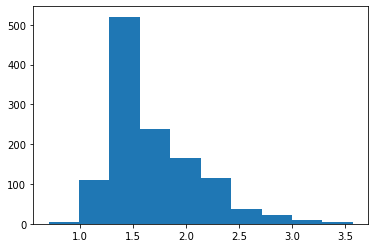

In [23]:
import matplotlib.pyplot as plt 
plt.hist(y_pred)

In [31]:
pm.traceplot(trace)

ImportError: ArviZ is not installed. In order to use `plot_trace`:
pip install arviz

[Text(0.5, 1.0, 'Posterior predictive of the mean'),
 Text(0.5, 0, 'mean(x)'),
 Text(0, 0.5, 'Frequency')]

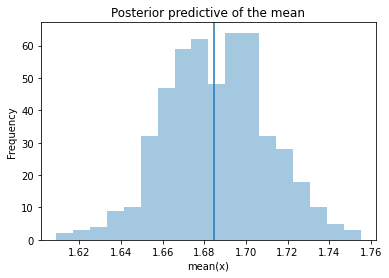

In [27]:
import matplotlib.pyplot as plt 
import seaborn as sns

ax = plt.subplot();
sns.distplot([n.mean() for n in ppc['y']], kde=False, ax=ax);
ax.axvline(rush['log1p_target'].mean());
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency')

### Writing function to back test model accuracy

#### Analyzing Bayesian OLS Output

In [30]:
plt.figure(figsize=(7, 7))
#plt.plot(x, y, 'x', label='data')
pm.plot_posterior_predictive_glm(trace, samples=100,
                              label='posterior predictive regression lines')


# plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

# plt.title('Posterior predictive regression lines')
# plt.legend(loc=0)
# plt.xlabel('x')
# plt.ylabel('y');

KeyError: 'x'

<Figure size 504x504 with 0 Axes>

### Robust Bayesian Regression

In [27]:
with pm.Model() as model_robust:
    family = pm.glm.families.StudentT()
    pm.glm.GLM.from_formula(f, rush, family=family)
    trace_robust = pm.sample(draws = 700, cores=4, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, lag2_rush_fantasy_pts, lag2_TD, lag2_Yds, fantasy_pts_ratio, yds_ratio, last_week_Yds, last_week_TD, last_week_rush_fantasy_pts, Intercept]
Sampling 4 chains: 100%|██████████| 4800/4800 [06:07<00:00, 13.05draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
# Simply running PPC will use the updated values and do prediction
ppc_robust = pm.sample_posterior_predictive(trace_robust, model=model, samples=100)